In [1]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

from glob import glob
from tqdm import tqdm

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(f'Available GPU number: {len(physical_devices)}')
tf.config.experimental.set_memory_growth(physical_devices[0], True)

Available GPU number: 1


In [3]:
path_to_dataset = r'.\Forest fire'
path_to_training_dataset = os.path.join(path_to_dataset, 'Training')
path_to_validation_dataset = os.path.join(path_to_dataset, 'Validation')
path_to_testing_dataset = os.path.join(path_to_dataset, 'Testing')

In [4]:
def preprocessData(path):
    path_to_positive = os.path.join(path, 'fire')
    path_to_negative = os.path.join(path, 'nofire')

    images_positive = glob(path_to_positive + '/*.*')
    images_negative = glob(path_to_negative + '/*.*')

    images_list, labels_list = [], []
    for image in tqdm(images_positive):
        img = cv2.imread(image)
        img = cv2.cvtColor(img, code=cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (200, 200))
        images_list.append(img)
        labels_list.append(1)

    for image in tqdm(images_negative):
        img = cv2.imread(image)
        img = cv2.resize(img, (200, 200))
        images_list.append(img)
        labels_list.append(0)
    
    return images_list, labels_list

In [5]:
training_images_list, training_labels_list = preprocessData(path_to_training_dataset)
validation_images_list, validation_labels_list = preprocessData(path_to_validation_dataset)
testing_images_list, testing_labels_list = preprocessData(path_to_testing_dataset)

100%|██████████| 46/46 [00:00<00:00, 204.69it/s]


In [6]:
def createDataFrame(images, labels):
    dataframe = pd.DataFrame()
    dataframe['image'] = images
    dataframe['label'] = labels
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    return dataframe

dataframe_training = createDataFrame(training_images_list, training_labels_list)
dataframe_testing = createDataFrame(testing_images_list, testing_labels_list)
dataframe_validation = createDataFrame(validation_images_list, validation_labels_list)

In [7]:
X_train, y_train = dataframe_training['image'], dataframe_training['label']
X_test, y_test = dataframe_testing['image'], dataframe_testing['label']
X_val, y_val = dataframe_validation['image'], dataframe_validation['label']

def reshapeTensors(array_to_reshape, length):
    tensor = []
    for i in tqdm(range(length)):
        element = np.array(array_to_reshape[i].reshape(200, 200, 3))
        tensor.append(element)
    tensor = np.array(tensor)
    return tensor

X_train = reshapeTensors(X_train, X_train.shape[0]) / 255
X_test = reshapeTensors(X_test, X_test.shape[0]) / 255
X_val = reshapeTensors(X_val, X_val.shape[0]) / 255

100%|██████████| 497/497 [00:00<00:00, 8739.49it/s]


In [8]:
train_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255, 
                                                                       horizontal_flip=True, 
                                                                       rotation_range=10, 
                                                                       width_shift_range=2, 
                                                                       fill_mode='nearest')
validation_data_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)

train_dataset = train_data_generator.flow_from_directory(path_to_training_dataset, 
                                                            target_size=(200, 200),
                                                            batch_size=32,
                                                            class_mode='binary')
validation_dataset = validation_data_generator.flow_from_directory(path_to_validation_dataset,
                                                                      target_size=(200, 200),
                                                                      batch_size=32,
                                                                      class_mode='binary')

Found 1706 images belonging to 2 classes.
Found 497 images belonging to 2 classes.


In [9]:
from tensorflow.keras.applications import ResNet152V2
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import GlobalMaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [15]:
model_resnet152V2 = ResNet152V2(include_top=False, weights='imagenet', input_shape=(200, 200, 3))
output_layer = model_resnet152V2.layers[-1].output
output_layer = GlobalMaxPooling2D()(output_layer)
output_layer = Flatten()(output_layer)
output_layer = Dropout(0.4)(output_layer)

model_resnet152V2 = Model(inputs=model_resnet152V2.input, outputs=output_layer)
model_resnet152V2.summary()

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200, 200, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 206, 206, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 100, 100, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
pool1_pad (ZeroPadding2D)       (None, 102, 102, 64) 0           conv1_conv[0][0]                 
_______________________________________________________________________________________

In [16]:
for layer in model_resnet152V2.layers:
    layer.trainable = False

In [17]:
model = Sequential()
model.add(model_resnet152V2)
model.add(Dense(1024, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(1, activation='sigmoid'))

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
functional_1 (Functional)    (None, 2048)              58331648  
_________________________________________________________________
dense (Dense)                (None, 1024)              2098176   
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0

In [19]:
model.compile(optimizer=RMSprop(learning_rate=0.0001),
                 loss=BinaryCrossentropy(), metrics=['accuracy'])

In [16]:
history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), verbose=1)

Epoch 1/10
54/54 [==============================] - 130s 2s/step - loss: 2.0503 - accuracy: 0.6284 - val_loss: 0.6972 - val_accuracy: 0.7646
Epoch 2/10
54/54 [==============================] - 101s 2s/step - loss: 0.8907 - accuracy: 0.7667 - val_loss: 0.5917 - val_accuracy: 0.8370
Epoch 3/10
54/54 [==============================] - 88s 2s/step - loss: 0.4647 - accuracy: 0.8669 - val_loss: 0.7283 - val_accuracy: 0.8310
Epoch 4/10
54/54 [==============================] - 110s 2s/step - loss: 0.3583 - accuracy: 0.9056 - val_loss: 0.9107 - val_accuracy: 0.8330
Epoch 5/10
54/54 [==============================] - 92s 2s/step - loss: 0.2358 - accuracy: 0.9426 - val_loss: 0.9327 - val_accuracy: 0.8491
Epoch 6/10
54/54 [==============================] - 116s 2s/step - loss: 0.1637 - accuracy: 0.9572 - val_loss: 1.0001 - val_accuracy: 0.8551
Epoch 7/10
54/54 [==============================] - 102s 2s/step - loss: 0.1119 - accuracy: 0.9660 - val_loss: 1.6931 - val_accuracy: 0.8270
Epoch 8/10
54/5

In [17]:
tf.keras.models.save_model(model, 'ResNet125V2.h5')

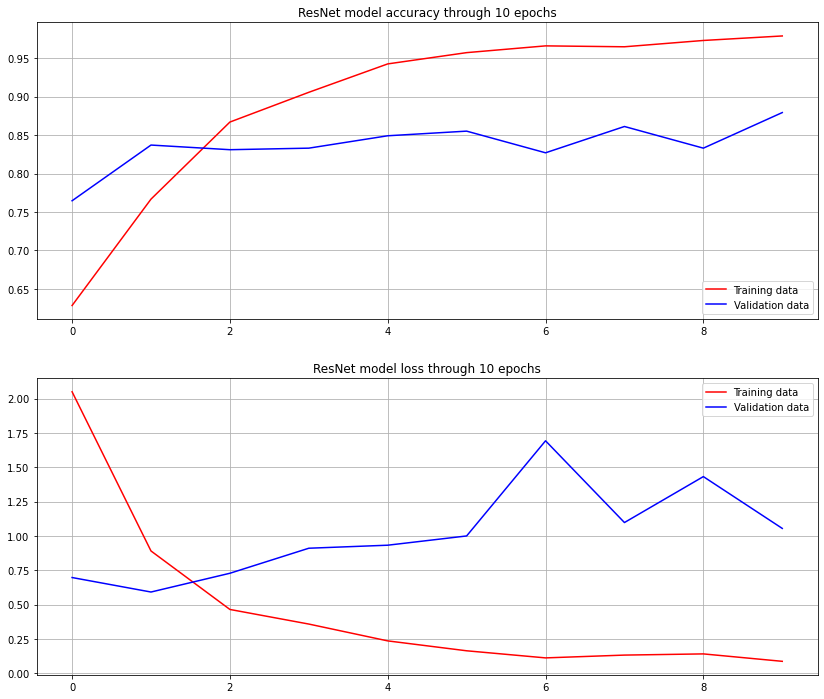

In [19]:
fig = plt.figure(figsize=(14, 12))
ax1 = fig.add_subplot(211)
ax1.set_title('ResNet model accuracy through 10 epochs')
ax1.plot(history.history['accuracy'], color='red', label='Training data')
ax1.plot(history.history['val_accuracy'], color='blue', label='Validation data')
ax1.grid(True)
ax1.legend(loc='lower right')
ax2 = fig.add_subplot(212)
ax2.set_title('ResNet model loss through 10 epochs')
ax2.plot(history.history['loss'], color='red', label='Training data')
ax2.plot(history.history['val_loss'], color='blue', label='Validation data')
ax2.grid(True)
ax2.legend(loc='upper right')

In [11]:
prediction = model.predict(X_test)
prediction = np.round(prediction)
prediction = prediction.reshape(-1).astype(np.int32)
y_test = np.array(y_test)

In [12]:
accuracy_score(y_test, prediction)

1.0

In [13]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        46
           1       1.00      1.00      1.00        22

    accuracy                           1.00        68
   macro avg       1.00      1.00      1.00        68
weighted avg       1.00      1.00      1.00        68



<AxesSubplot:>

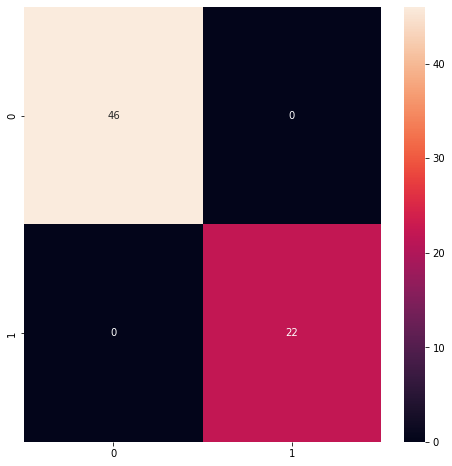

In [14]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
sns.heatmap(confusion_matrix(y_test, prediction), annot=True, fmt='d', ax=ax)

In [20]:
%%time
history = model.fit(train_dataset, batch_size=32, epochs=10, validation_data=validation_dataset, verbose=1)

Epoch 1/10
54/54 [==============================] - 132s 2s/step - loss: 2.0417 - accuracy: 0.6301 - val_loss: 0.4963 - val_accuracy: 0.8109
Epoch 2/10
54/54 [==============================] - 118s 2s/step - loss: 0.8780 - accuracy: 0.7778 - val_loss: 0.5651 - val_accuracy: 0.8149
Epoch 3/10
54/54 [==============================] - 110s 2s/step - loss: 0.6005 - accuracy: 0.8511 - val_loss: 0.5672 - val_accuracy: 0.8652
Epoch 4/10
54/54 [==============================] - 112s 2s/step - loss: 0.3618 - accuracy: 0.9039 - val_loss: 0.7084 - val_accuracy: 0.8592
Epoch 5/10
54/54 [==============================] - 154s 3s/step - loss: 0.3180 - accuracy: 0.9244 - val_loss: 0.8403 - val_accuracy: 0.8229
Epoch 6/10
54/54 [==============================] - 109s 2s/step - loss: 0.2600 - accuracy: 0.9297 - val_loss: 0.8305 - val_accuracy: 0.8410
Epoch 7/10
54/54 [==============================] - 109s 2s/step - loss: 0.2567 - accuracy: 0.9402 - val_loss: 1.0282 - val_accuracy: 0.8249
Epoch 8/10
54

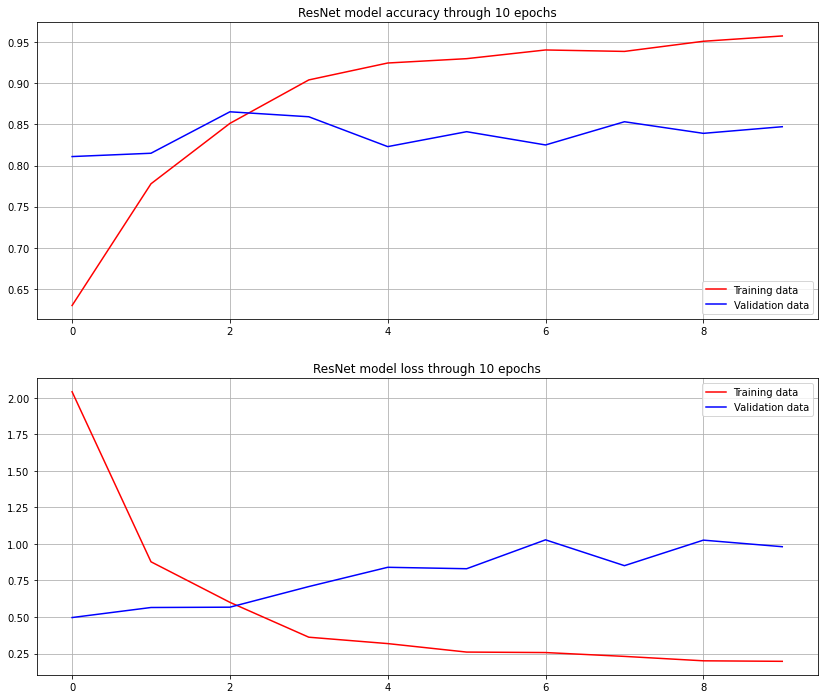

In [21]:
fig = plt.figure(figsize=(14, 12))
ax1 = fig.add_subplot(211)
ax1.set_title('ResNet model accuracy through 10 epochs')
ax1.plot(history.history['accuracy'], color='red', label='Training data')
ax1.plot(history.history['val_accuracy'], color='blue', label='Validation data')
ax1.grid(True)
ax1.legend(loc='lower right')
ax2 = fig.add_subplot(212)
ax2.set_title('ResNet model loss through 10 epochs')
ax2.plot(history.history['loss'], color='red', label='Training data')
ax2.plot(history.history['val_loss'], color='blue', label='Validation data')
ax2.grid(True)
ax2.legend(loc='upper right')

In [31]:
prediction = model.predict(X_test)
prediction = np.trunc(prediction)
prediction = prediction.reshape(-1).astype(np.int32)
y_test = np.array(y_test)

In [32]:
accuracy_score(y_test, prediction)

0.5735294117647058

In [33]:
print(classification_report(y_test, prediction))

              precision    recall  f1-score   support

           0       0.64      0.85      0.73        46
           1       0.00      0.00      0.00        22

    accuracy                           0.57        68
   macro avg       0.32      0.42      0.36        68
weighted avg       0.43      0.57      0.49        68



<AxesSubplot:>

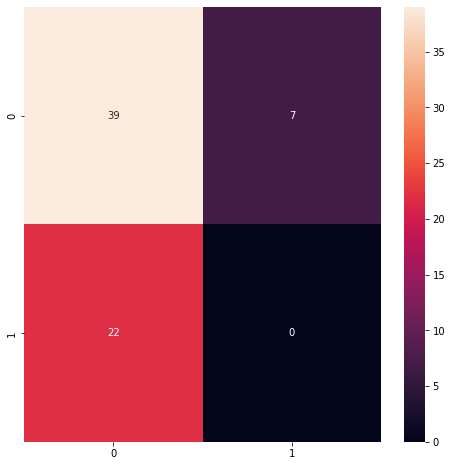

In [34]:
fig = plt.figure(figsize=(8, 8))
ax = fig.add_subplot(111)
sns.heatmap(confusion_matrix(y_test, prediction), annot=True, fmt='d', ax=ax)

In [10]:
model = tf.keras.models.load_model('ResNet125V2.h5')